# Orders - Multivariate Regression of  the `review_score`

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# Import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf


⚠️ You are strongly advised to:
* 💾 download the solution for yesterday's optional `distance_seller_customer` function if you didn't have time to code it
* 👥 copy-paste it into your `olist/order.py` file



👇 First things first, import the `orders` dataset

In [3]:
from olist.order import Order
orders = Order().get_training_data(with_distance_seller_customer=True)


Let's recall our simple analysis from yesterday's exercise: 

Based on our correlation matrix down below 👇, we can notice that `review_score` is mostly correlated with  two features : `wait_time` and `delay_vs_expected`. However, these two features are also highly correlated with each other. 

In this exercise, we will use `statsmodels` to distinguish the effect of one feature, **holding the other features constant**.

In [4]:
orders.head()


,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,8.4,15.5,0.0,delivered,0,0,4,1,1,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,13.8,19.1,0.0,delivered,0,0,4,1,1,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,9.4,26.6,0.0,delivered,1,0,5,1,1,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,13.2,26.2,0.0,delivered,1,0,5,1,1,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,2.9,12.1,0.0,delivered,1,0,5,1,1,19.90,8.72


<AxesSubplot:>

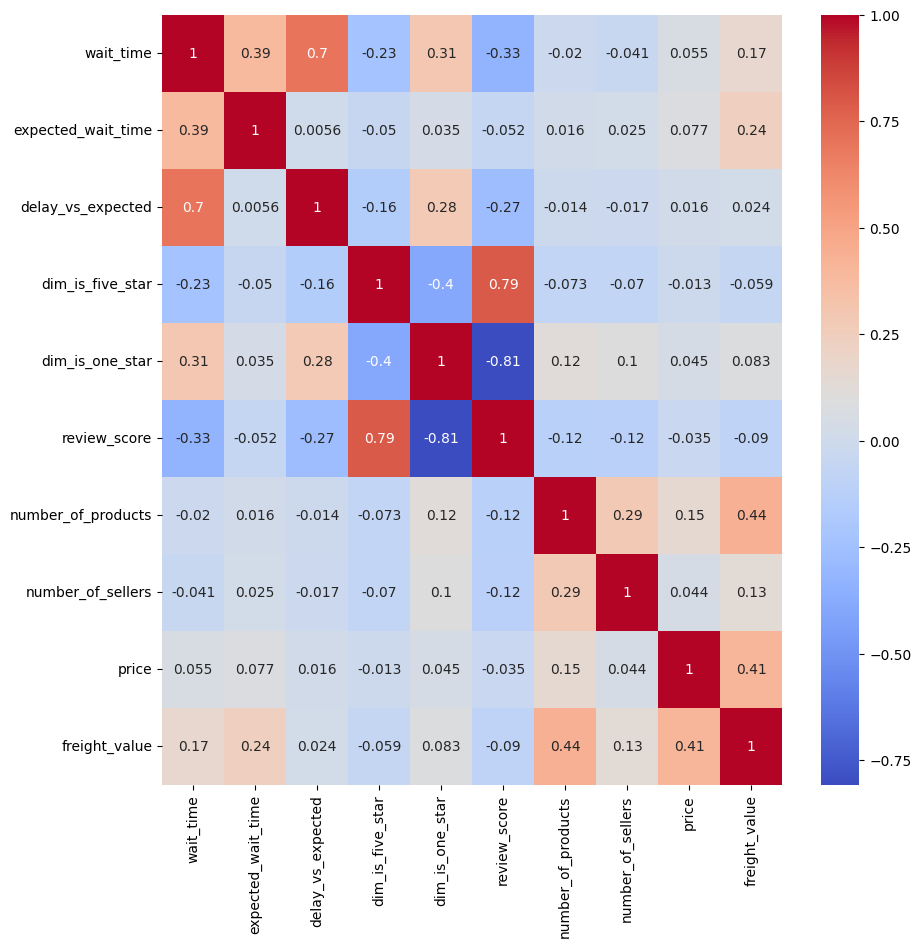

In [5]:
plt.figure(figsize = (10, 10))

sns.heatmap(
    orders.corr(),
    cmap = 'coolwarm',
    annot = True,
    annot_kws = {"size": 10}
)


## 1 - Univariate regression

❓Use [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.formula.api.ols.html) with `statsmodels.formula.api` to quickly make
 - `model1`: an ols regression of `review_score` over `wait_time`
 - `model2`: an ols regression of `review_score` over `delay_vs_expected`

For each, print the `summary` table and interpret the results:
- Make sure to understand how these results match those of the seaborn regplot
- Read the regression performance metric `R-squared`, as well as `individual regression coefficients`, `t-values`, `p-values`, and `95% confidence intervals`

***Model 1***:

In [6]:
# YOUR CODE HERE
# Instanciate a model
model1 = smf.ols(formula='review_score ~ wait_time', data=orders)

# Train the model to find best line
model1 = model1.fit()
model1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                 1.208e+04
Date:                Wed, 18 Oct 2023   Prob (F-statistic):               0.00
Time:                        14:18:12   Log-Likelihood:            -1.5519e+05
No. Observations:               96353   AIC:                         3.104e+05
Df Residuals:                   96351   BIC:                         3.104e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7236      0.006    729.486      0.000       4.711       4.736
wait_time     -0.0454      0.000   -109.905      0.000      -0.046      -0.045
==============================================================================
Omnibus:                    19639.537   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35585.654
Skew:                          -1.300   Prob(JB):                         0.00
Kurtosis:                       4.449   Cond. No.                         26.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

***Model 2***:

In [7]:
# Instanciate a model
model2 = smf.ols(formula='review_score ~ delay_vs_expected', data=orders)

# Train the model to find best line
model2 = model2.fit()
model2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     7716.
Date:                Wed, 18 Oct 2023   Prob (F-statistic):               0.00
Time:                        14:18:12   Log-Likelihood:            -1.5717e+05
No. Observations:               96353   AIC:                         3.143e+05
Df Residuals:                   96351   BIC:                         3.144e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.2124      0.004   1043.902      0.000       4.205       4.220
delay_vs_expected    -0.0751      0.001    -87.841      0.000      -0.077      -0.073
==============================================================================
Omnibus:                    20752.877   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49854.549
Skew:                          -1.204   Prob(JB):                         0.00
Kurtosis:                       5.573   Cond. No.                         4.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 2 - Multivariate regression

❓ What is the impact on `review_score` of adding one day of `delay_vs_expected` to the order, **holding `wait_time` constant**? Which of the two features is the most explicative for the low `review_score`?

For that purpose, run an OLS model `model3` where both `wait_time` and `delay_vs_expected` are the features (independent variables), and `review_score` is the target (dependent variable)

***Model 3***:

In [8]:
# Instanciate a model
model3 = smf.ols(formula='review_score ~ wait_time + delay_vs_expected', data=orders)

# Train the model to find best line
model3 = model3.fit()
model3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     6212.
Date:                Wed, 18 Oct 2023   Prob (F-statistic):               0.00
Time:                        14:19:06   Log-Likelihood:            -1.5504e+05
No. Observations:               96353   AIC:                         3.101e+05
Df Residuals:                   96350   BIC:                         3.101e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.6500      0.008    602.762      0.000       4.635       4.665
wait_time            -0.0382      0.001    -66.017      0.000      -0.039      -0.037
delay_vs_expected    -0.0206      0.001    -17.487      0.000      -0.023      -0.018
==============================================================================
Omnibus:                    20080.011   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40618.914
Skew:                          -1.249   Prob(JB):                         0.00
Kurtosis:                       4.970   Cond. No.                         31.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

eval_env: 1
eval_env: 1
eval_env: 1


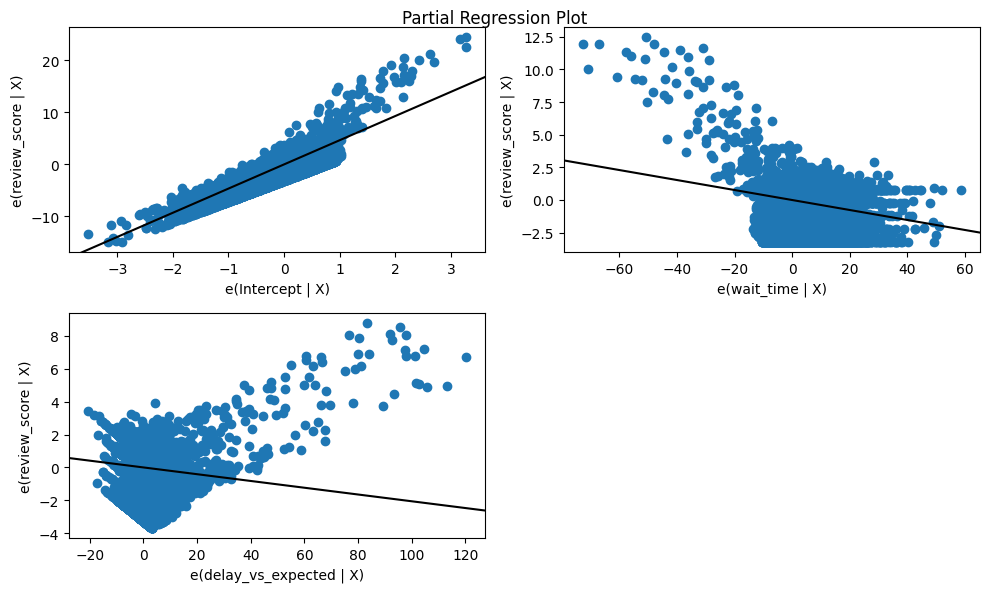

In [30]:
fig = plt.figure(figsize=(10,6))
fig = sm.graphics.plot_partregress_grid(model3, fig=fig)


----
👉 Our multivariate regression allows us to isolate the impact of one feature, while controlling the effect of other features. These new coefficients are called **`partial correlation coefficients`**. 

❓Can you notice the difference with the **simple regression** coefficients computed with *seaborn* above? 

❓What can you say about the relative slopes for `wait_time` and `delay_vs_expected`? 


> YOUR ANSWER HERE

<details>
    <summary>- 💡 Solution 💡-</summary>

- Holding `wait_time` constant, each additional day of `delay` reduces the review_score on average by 0.0205 [0.023 - 0.018] points
- Holding `delay` constant, each additional day of `wait_time` reduces the review_score on average by 0.0383 [0.039 - 0.037] points

Contrary to what was found with the simple bivariate correlation analysis, `delay` is actually less impactful than `wait_time` in driving lower `review_score`! This interesting finding demonstrates the importance of multi-variate regression to remove the potential impact of confounding factors

---
❌ R-squared is quite low: no more than 12% of the variations of review_score is explained by the combined variations of `wait_time` and `delay_vs_expected`. 

✅ Let's try to add more features to our regression to improve the explainability of the linear regression.

👉 Create a new OLS `model4` with more features from the `orders` dataset.
- ⚠️ Do not create **data leaks**: do not add features that are directly derived from the `review_score`
- ⚠️ Do not add two features perfectly collinear with each other
- ⚖️  Transform each feature $X_i$ into its respective z-score $Z_i = \frac{X_i - \mu_i}{\sigma_i}$ in order to compare the partial regression coefficients $\beta_i$ together. Otherwise, the $\beta_i$ won't be in the same dimension, meaning you'll be comparing apples (e.g. "review_stars per day") with oranges (e.g. "review_stars per BRL")!

📝 <u>Note</u>: a **`Multivariate Linear Regression`** is also called an **`Ordinary Least Squares`** method because in this model, we want to minimise the **`MSE Mean Squared Errors`**

***Model 4***:

❓ What features would you like to consider ?

In [99]:
features = orders[['review_score', 'wait_time', 'delay_vs_expected', 'number_of_products', 'number_of_sellers']].copy()


⚖️ Standardize your features.

*Do you remember why we need to perform this operation before running a `Multivariate regression` ?*

<details>
    <summary>- 💡 Answer 💡-</summary>

👉 In a `multivariate linear regression`, we are trying to measure the impact of each feature on the target. 
    
⚠️ Because of scale effects, some features will wrongly be seen as more important than others 
    
    *Ex: if you have a feature "number of bedrooms" from 1 to 5 and a feature "surface" from 20 to 200 sqm, the ranges of these two features are quite different...*

📅 When we will discover Machine Learning Algorithms, we will also need to perform some scaling operations before trying to predict any target.

In [114]:
# Compute Z-Scores for each feature to compare the partial regression coefficients
selected_features = ['wait_time', 'delay_vs_expected', 'number_of_products', 'number_of_sellers']


for feature in selected_features:
    features[[feature]] = (features[[feature]] - features[[feature]].mean()) / features[[feature]].std()
z_scores = features
z_scores


,review_score,wait_time,delay_vs_expected,number_of_products,number_of_sellers
0,4,-0.435948,-0.162126,-0.264657,-0.112588
1,4,0.135051,-0.162126,-0.264657,-0.112588
2,5,-0.330207,-0.162126,-0.264657,-0.112588
3,5,0.071607,-0.162126,-0.264657,-0.112588
4,5,-1.017520,-0.162126,-0.264657,-0.112588
...,...,...,...,...,...
96356,5,-0.457096,-0.162126,-0.264657,-0.112588
96357,4,1.023271,-0.162126,-0.264657,-0.112588
96358,5,1.308770,-0.162126,-0.264657,-0.112588
96359,2,0.483995,-0.162126,1.603238,-0.112588


👉 Create your `model4` and train it.

In [115]:
# YOUR CODE HERE
model4 = smf.ols(formula='review_score ~ wait_time + delay_vs_expected + number_of_products + number_of_sellers', data=z_scores)

# Train the model to find best line
model4 = model4.fit()
model4.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     3936.
Date:                Wed, 18 Oct 2023   Prob (F-statistic):               0.00
Time:                        15:53:45   Log-Likelihood:            -1.5359e+05
No. Observations:               96353   AIC:                         3.072e+05
Df Residuals:                   96348   BIC:                         3.072e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.1557      0.004   1082.763      0.000       4.148       4.163
wait_time             -0.3715      0.005    -68.808      0.000      -0.382      -0.361
delay_vs_expected     -0.0928      0.005    -17.194      0.000      -0.103      -0.082
number_of_products    -0.1300      0.004    -32.419      0.000      -0.138      -0.122
number_of_sellers     -0.1295      0.004    -32.285      0.000      -0.137      -0.122
==============================================================================
Omnibus:                    18936.096   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38782.960
Skew:                          -1.173   Prob(JB):                         0.00
Kurtosis:                       5.039   Cond. No.                         2.40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---
❓ What are the most important features? (make a bar chart to visualize them well)
- How has the overall regression performance changed?
- Is this regression statistically significant?

In [116]:
coefficient_df = pd.DataFrame(model4.params).reset_index().rename(columns={'index': 'feature', 0: 'coefficient'})
coefficient_df = coefficient_df[coefficient_df['feature'] != 'Intercept']
coefficient_df


,feature,coefficient
1,wait_time,-0.371542
2,delay_vs_expected,-0.092779
3,number_of_products,-0.129959
4,number_of_sellers,-0.129523


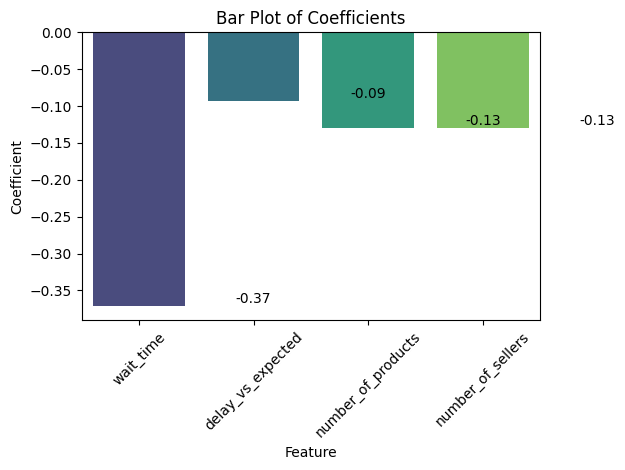

In [117]:
ax = sns.barplot(data=coefficient_df, x='feature', y='coefficient', palette='viridis')
plt.title('Bar Plot of Coefficients')
plt.xlabel('Feature')
plt.ylabel('Coefficient')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Add values on top of each bar (optional)
for index, row in coefficient_df.iterrows():
    ax.text(index, row['coefficient'], f"{row['coefficient']:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


<details>
    <summary>- 💡Explanations 💡 -</summary>
    

- `wait_time` is the biggest explanatory variable
- The more `products` and `sellers` there are for a single order, the lower the `review_score` seems to be
- Distance also plays a role in customers' satisfaction.
- Depending on your choice of feature, you may not be able to conclude anything about `price` and `freight_value` if their p-values are too high
    
- Overall, this multivariate regression remains statistically significant, because its F-statistics are much greater than 1 (at least one feature has a very low p-value)

- R-squared hasn't increased by much. Most of the explainability of `review_score` lies outside of the orders dataset.

⚠️ Low R-squared is common when the number of observations (n) is much higher than the number of features (p). Relevant insights can still be derived from such regressions, provided they are statistically significant
</details>



## 3 - Check model performance

⚠️ Regression performance should not be measured only by its R-squared!  

👀 Always visualize the distribution of the predictions, and especially the residuals.

❓ Compute the residuals.

You should see that the mean of the residuals is equal to 0 (always verified in a linear regression context)

In [120]:
predicted_review_score = pd.DataFrame(model4.predict(z_scores[['wait_time', 'delay_vs_expected', 'number_of_products', 'number_of_sellers']]))
review_score = orders[['review_score']].rename(columns={'review_score': 0})

residuals = (predicted_review_score - review_score).rename(columns={0: 'residuals'})
residuals


,residuals
0,0.381680
1,0.169530
2,-0.657607
3,-0.806898
4,-0.402242
...,...
96356,-0.610463
96357,-0.160481
96358,-1.266556
96359,1.797134


🧮 Compute the associated RMSE.

In [126]:
residuals['residuals_squared'] = residuals['residuals'] ** 2
mse = residuals['residuals_squared'].mean()
rmse = np.sqrt(mse)

rmse


1.1913267824678122

📊 Plot the `residuals` in a histogram.

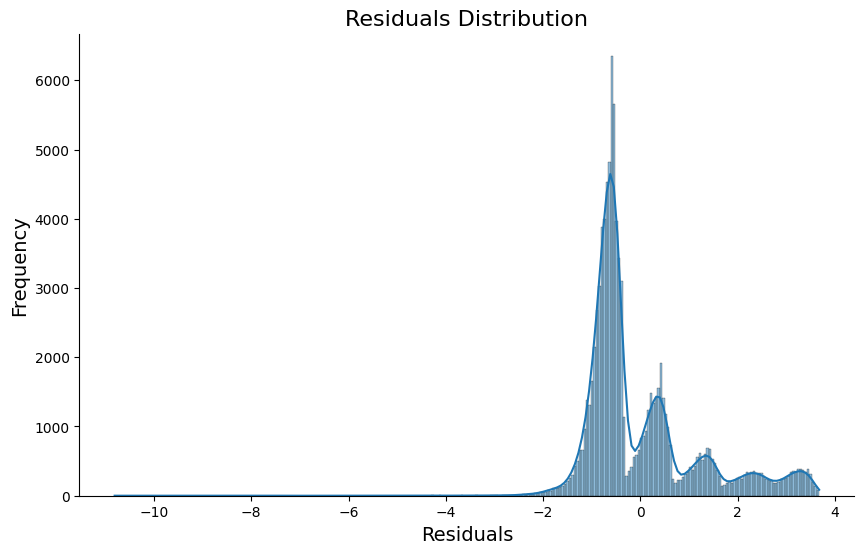

In [129]:
plt.figure(figsize=(10, 6))
sns.histplot(data=residuals, x='residuals', kde=True)

plt.title('Residuals Distribution', fontsize=16)
plt.xlabel('Residuals', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

sns.set_style("whitegrid")
sns.despine()

plt.show()


❓ Can you guess why the residual distplot has such a strange shape? 

*Hint:*<br/>
👉 Plot, on the same graph, both the distribution of the `review_score` and the distribution of the `predicted_review_score`.

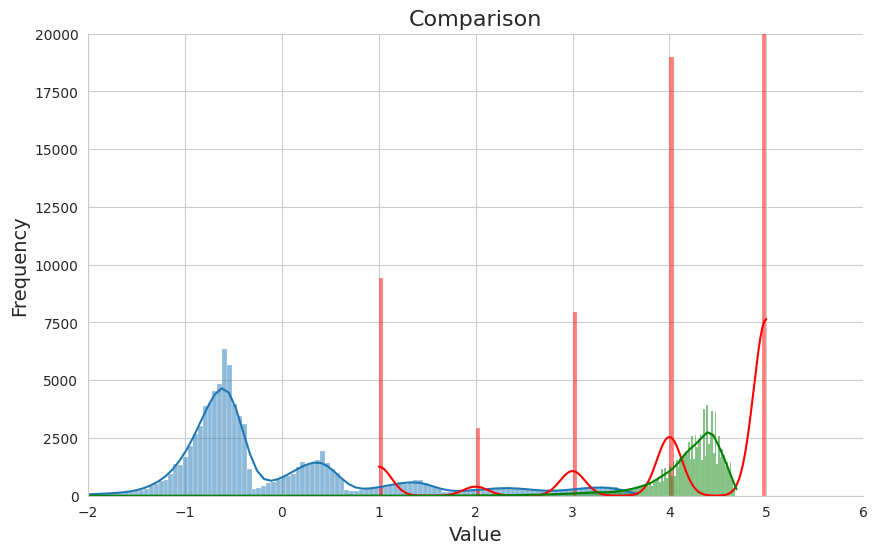

In [134]:
plt.figure(figsize=(10, 6))
sns.histplot(data=residuals, x='residuals', kde=True)
sns.histplot(data=review_score, x=0, kde=True, color='red')
sns.histplot(data=predicted_review_score, x=0, kde=True, color='green')

plt.xlim(-2, 6)  # Set the x-axis limits from -2 to 2
plt.ylim(0, 20000)  # Set the y-axis limits from 0 to 2000

plt.title('Comparison', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

sns.set_style("whitegrid")
sns.despine()

plt.show()


📈 Actually, using `seaborn`, we could have already plotted a `regression line` of the `review_score` vs. the `delay_vs_expected`

Do it once with a sub-`sample` of the population, and once with the `entire population`.

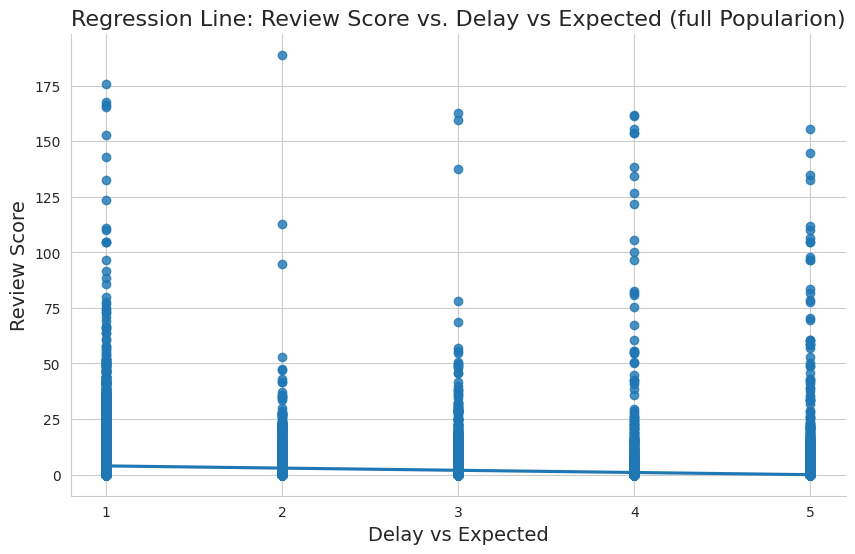

In [138]:
plt.figure(figsize=(10, 6))
sns.regplot(data=orders, x='review_score', y='delay_vs_expected')

plt.xticks(ticks=[1, 2, 3 ,4 ,5])

plt.title('Regression Line: Review Score vs. Delay vs Expected (full Popularion)', fontsize=16)
plt.xlabel('Delay vs Expected', fontsize=14)
plt.ylabel('Review Score', fontsize=14)

sns.set_style("whitegrid")
sns.despine()

plt.show()


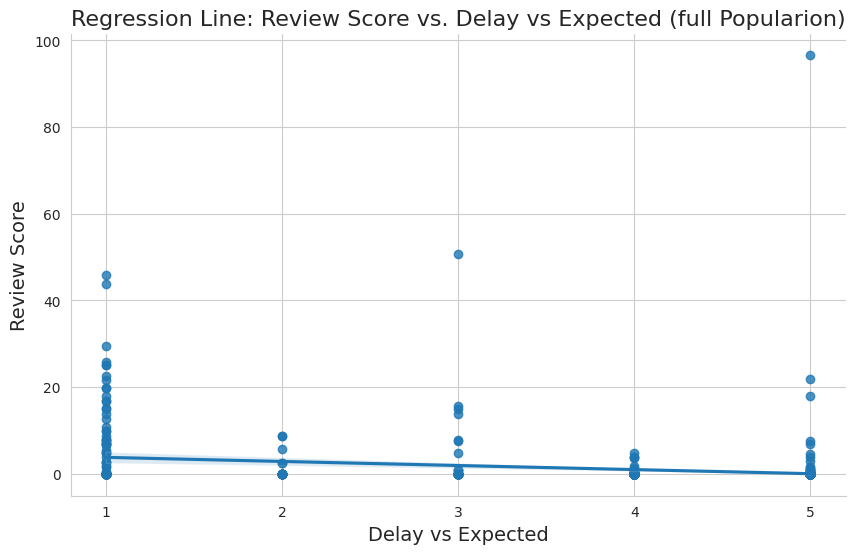

In [139]:
plt.figure(figsize=(10, 6))
sns.regplot(data=orders.sample(1000, random_state=1), x='review_score', y='delay_vs_expected')

plt.xticks(ticks=[1, 2, 3 ,4 ,5])

plt.title('Regression Line: Review Score vs. Delay vs Expected (full Popularion)', fontsize=16)
plt.xlabel('Delay vs Expected', fontsize=14)
plt.ylabel('Review Score', fontsize=14)

sns.set_style("whitegrid")
sns.despine()

plt.show()


☝️ You can see that it is hard to regress the `review_score` of an order vs. its `wait_time`. because the `review_score` is a discrete number that could also be interpreted as a category: 1 (very bad), 2 (bad), 3 (average), 4 (good), 5 (excellent).

📅 In the next session, you will discover a new model: the `Logistic Regression` which, despite its name, is a `Classification Algorithm` 

☝️ So in the end, our model is not so great, for two reasons:
- First, because we don't have enough features to explain a significant proportion of the review_scores (low R-squared)
- Second, because we are trying to fit a "linear regression" function to a discrete classification problem

💡 So instead on working on individual orders and trying to explain their discrete `review_score` based on the `wait_time`, we will focus our analysis on the sellers' level, aggregating the orders by sellers in the next challenge.

🏁 Great job! 

💾 Don't forget to *save*, *commit* and *push* this notebook when you are done!